# 可以先執行 pip install -r requirements.txt
# 使用Jupyter NoteBook 執行
# 靜態網頁 匯率

# 第一小題

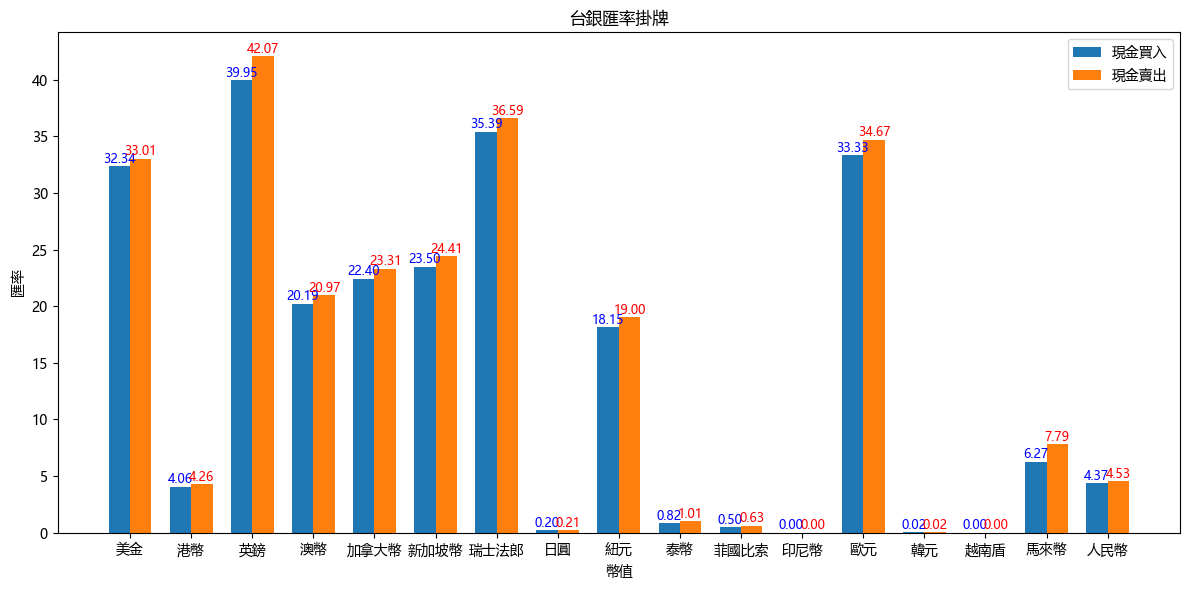

In [6]:
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np

# 抓取台銀匯率掛牌價
def fetch_exchange_rates():
    url = "https://rate.bot.com.tw/xrt?Lang=zh-TW"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    exchange_rates = []
    rows = soup.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        if cols and len(cols) >= 5:
            currency = cols[0].find('div', class_='visible-phone').text.strip().split(' ')[0]  # 只取中文部分
            cash_rate_buy = cols[1].text.strip()
            cash_rate_sell = cols[2].text.strip()
            spot_rate_buy = cols[3].text.strip()
            spot_rate_sell = cols[4].text.strip()
            exchange_rates.append({
                'currency': currency,
                'cash_rate_buy': cash_rate_buy,
                'cash_rate_sell': cash_rate_sell,
                'spot_rate_buy': spot_rate_buy,
                'spot_rate_sell': spot_rate_sell,
            })
    return exchange_rates

# 將匯率資料進行視覺化呈現
def visualize_exchange_rates(exchange_rates):
    # 過濾掉不完整的數據
    valid_rates = [rate for rate in exchange_rates if rate['cash_rate_buy'] != '-' and rate['cash_rate_sell'] != '-']
    
    currencies = [rate['currency'] for rate in valid_rates]
    cash_rate_buy = [float(rate['cash_rate_buy']) for rate in valid_rates]
    cash_rate_sell = [float(rate['cash_rate_sell']) for rate in valid_rates]

    x = np.arange(len(currencies))
    width = 0.35

    # 設置字體以支持中文顯示
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei']
    plt.rcParams['axes.unicode_minus'] = False

    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width/2, cash_rate_buy, width, label='現金買入')
    bars2 = ax.bar(x + width/2, cash_rate_sell, width, label='現金賣出')

    ax.set_xlabel('幣值')
    ax.set_ylabel('匯率')
    ax.set_title('台銀匯率掛牌')
    ax.set_xticks(x)
    ax.set_xticklabels(currencies)
    ax.legend()

    # 在條形圖上添加數值標籤
    for bar1, bar2 in zip(bars1, bars2):
        height1 = bar1.get_height()
        height2 = bar2.get_height()
        
        ax.text(bar1.get_x() + bar1.get_width() / 2, height1 + 0.05, f'{height1:.2f}', 
                ha='center', va='bottom', fontsize=9, color='blue')
        ax.text(bar2.get_x() + bar2.get_width() / 2, height2 + 0.05, f'{height2:.2f}', 
                ha='center', va='bottom', fontsize=9, color='red')

    fig.tight_layout()
    plt.show()

if __name__ == "__main__":
    # 抓取匯率資料
    exchange_rates = fetch_exchange_rates()
    
    # 顯示抓取的匯率資料
    #for rate in exchange_rates:
    #    print(rate)

    # 視覺化匯率資料
    visualize_exchange_rates(exchange_rates)


# 第二小題

日期範圍：2024-07-08 00:00:00 到 2025-01-07 00:00:00，共 184 天
買入： ['32.335', '32.465', '32.515', '32.48', '32.385', '32.325', '32.32', '32.3', '32.275', '32.28', '32.29', '32.295', '32.27', '32.09', '32.115', '32.085', '32.105', '32.09', '32.11', '32.045', '32.075', '32.005', '32.04', '32.035', '32.14', '32.2', '32.07', '32.13', '32.135', '32.11', '32.08', '32.19', '32.145', '32.095', '32.01', '32.135', '32.07', '32.165', '32.05', '32.035', '31.85', '31.715', '31.84', '31.775', '31.57', '31.57', '31.565', '31.64', '31.64', '31.7', '31.695', '31.67', '31.69', '31.68', '31.66', '31.57', '31.67', '31.765', '31.785', '31.78', '31.77', '31.785', '31.78', '31.82', '31.73', '31.56', '31.44', '31.25', '31.29', '31.465', '31.44', '31.57', '31.635', '31.565', '31.535', '31.54', '31.51', '31.595', '31.73', '31.725', '31.78', '31.69', '31.53', '31.67', '31.79', '31.66', '31.62', '31.54', '31.51', '31.55', '31.53', '31.41', '31.56', '31.565', '31.535', '31.58', '31.625', '31.88', '31.88', '31.9', '32.075'

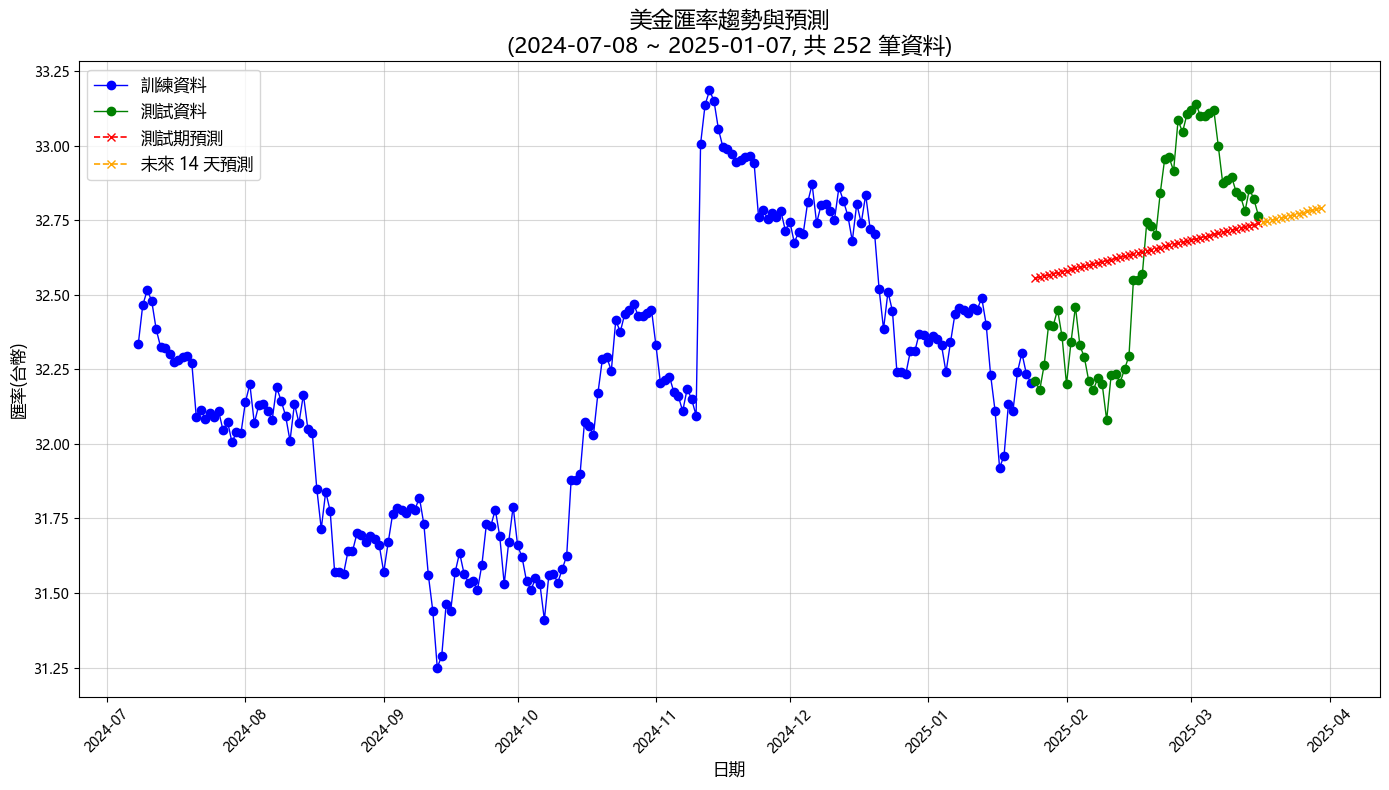

In [8]:
import requests
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error


# 工具函數：逐層尋找節點
def find_element(parent, tag, **kwargs):
    element = parent.find(tag, **kwargs)
    if not element:
        raise ValueError(f"找不到符合條件的 {tag}，條件：{kwargs}")
    return element


# 評估模型準確率
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    # 以平均值為基準，轉換為「準確率」
    accuracy = 100 - (mae / np.mean(y_true)) * 100
    return accuracy


url = "https://rate.bot.com.tw/xrt/quote/l6m/USD"

# 發送 HTTP 請求
response = requests.get(url)

if response.status_code == 200:
    soup = BeautifulSoup(response.text, 'html.parser')
    try:
        # 取得日期範圍
        chart_key_values = find_element(soup, 'div', class_='row chart-key-values')
        date_div = find_element(chart_key_values, 'div', class_='chart-key-value')
        date_value = find_element(date_div, 'div', class_='value').text.strip()
        start_date_str, end_date_str = map(str.strip, date_value.split('-'))
        start_date = pd.to_datetime(start_date_str, format='%Y/%m/%d')
        end_date = pd.to_datetime(end_date_str, format='%Y/%m/%d')
        total_days = (end_date - start_date).days + 1
        
        print(f"日期範圍：{start_date} 到 {end_date}，共 {total_days} 天")

        # 逐層尋找匯率資料
        page_wrapper = find_element(soup, 'div', class_='page-wrapper')
        main_section = find_element(page_wrapper, 'main', class_='main')
        ie11_and_above = find_element(main_section, 'div', id='ie11andabove')
        container = find_element(ie11_and_above, 'div', class_='container')
        table = find_element(container, 'table', class_='table table-striped table-bordered table-condensed table-hover')
        tbody = find_element(table, 'tbody')

        # 找到所有符合條件的 td
        tds = tbody.find_all('td', class_='rate-content-cash text-right print_table-cell')

        # 分別儲存奇數(買入)與偶數(賣出)的資料
        odd_data = [td.text.strip() for index, td in enumerate(tds) if index % 2 == 0]
        even_data = [td.text.strip() for index, td in enumerate(tds) if index % 2 != 0]

        # 印出結果 (可視需要保留或註解)
        print("買入：", odd_data)
        print("賣出：", even_data)

    except ValueError as e:
        print(e)
else:
    print(f"無法請求網頁，狀態碼：{response.status_code}")


# odd_data 與 even_data 皆為數值型態
odd_data = [float(value) for value in odd_data]
even_data = [float(value) for value in even_data]

# 將兩組資料合併成完整的時間序列
time_series = odd_data + even_data

# 建立日期索引（假設資料量與實際天數對應）
dates = pd.date_range(start=start_date, periods=len(time_series), freq='D')

# 準備資料 (X 為索引, y 為數值)
X = np.arange(len(time_series)).reshape(-1, 1)
y = np.array(time_series)


# =========== 修正點：以 80% 作為訓練集、20% 作為測試集，提升評估參考價值 ===========

train_size = int(len(y) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 建立並訓練模型
model = LinearRegression()
model.fit(X_train, y_train)

# 在測試集上進行預測
y_pred_test = model.predict(X_test)

# 計算誤差指標
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
accuracy_test = evaluate_model(y_test, y_pred_test)

print(f"=== 測試集評估 (約 20% 的資料) ===")
print(f"MSE: {mse_test:.4f}")
print(f"MAE: {mae_test:.4f}")
print(f"準確率: {accuracy_test:.2f}%")
print("================================")


# =========== 修正點：預測未來天數，建議 7~14 天，以提高參考性 ===========

future_days = 14  # 您可依需求調整，如 7, 10, 14, 30 等
future_index = np.arange(len(y), len(y) + future_days).reshape(-1, 1)
future_predictions = model.predict(future_index)

future_dates = pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=future_days, freq='D')


# =========== 繪製圖表 ===========

plt.figure(figsize=(14, 8))
# 過去(含訓練期)與測試期 數據點
plt.plot(dates[:train_size], y[:train_size], label="訓練資料", marker='o', linewidth=1, color='blue')
plt.plot(dates[train_size:], y[train_size:], label="測試資料", marker='o', linewidth=1, color='green')

# 在測試區間上，顯示預測線以便比較
plt.plot(dates[train_size:], y_pred_test, label="測試期預測", linestyle='--', marker='x', linewidth=1.2, color='red')

# 未來預測
plt.plot(future_dates, future_predictions, label=f"未來 {future_days} 天預測", linestyle='--', marker='x', linewidth=1.2, color='orange')

# 圖表設定
plt.title(f"美金匯率趨勢與預測\n({start_date.date()} ~ {end_date.date()}, 共 {len(time_series)} 筆資料)", fontsize=16)
plt.xlabel("日期", fontsize=12)
plt.ylabel("匯率(台幣)", fontsize=12, rotation=90)  # 確保文字垂直顯示
plt.legend(fontsize=12)
plt.grid(alpha=0.5)

# x 軸美化
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


# 動態網頁 日本死亡人數預測

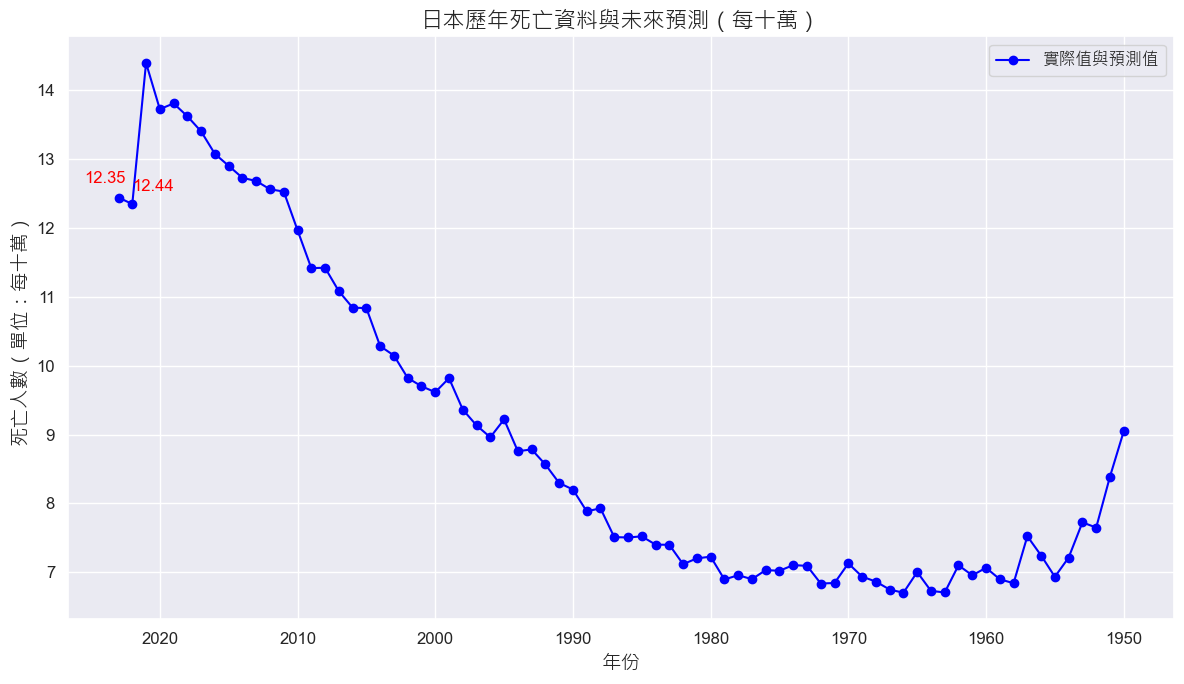

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import StaleElementReferenceException
import time
import numpy as np
from sklearn.linear_model import LinearRegression
import sys

def select_country_and_gender(driver, wait):
    driver.get("https://platform.who.int/mortality/themes/theme-details/MDB/all-causes")
    for attempt in range(3):
        try:
            search_input = wait.until(EC.presence_of_element_located((
                By.XPATH, "//div[@id='filter_clustered_column_chart_5_key']//input[@class='input-search' and @placeholder='Search...']"
            )))
            search_input.click()
            search_input.send_keys("Japan")
            break
        except StaleElementReferenceException:
            if attempt < 2:
                time.sleep(1)
            else:
                raise
    checkbox = wait.until(EC.element_to_be_clickable((
        By.XPATH, "//label[@id='filter_clustered_column_chart_5_key_JPN_label']//input[@type='checkbox']"
    )))
    checkbox.click()
    for gid in ["1", "2", "9"]:
        gender_span = wait.until(EC.element_to_be_clickable((
            By.XPATH, f"//span[@class='option-selected' and @id='{gid}']"
        )))
        gender_span.click()

def get_table_text(driver):
    td_elems = driver.find_elements(By.XPATH, "//tbody[@id='custom_table_body']//td[@class='right-align']")
    return "\n".join(t.text.strip() for t in td_elems)

def get_mortality_data(driver, wait, start_year=2021, end_year=1950):
    results = []
    scroll_done = False
    for year in range(start_year, end_year -1, -1):
        # 在處理每個年份時，顯示目前查詢的年份
        print_current_year(year)
        
        select_element = wait.until(EC.presence_of_element_located((
            By.XPATH, "//div[@id='filter_clustered_column_chart_7_key']//select"
        )))
        Select(select_element).select_by_value(str(year))
        old_text = get_table_text(driver)
        apply_button = wait.until(EC.element_to_be_clickable((
            By.XPATH, "//button[@id='filters_section_clustered_column_chart_key_filter_button']"
        )))
        driver.execute_script("arguments[0].scrollIntoView(true);", apply_button)
        driver.execute_script("arguments[0].click();", apply_button)
        wait.until(lambda d: get_table_text(d) != old_text)
        
        if not scroll_done:
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            scroll_done = True
        
        td_elems = wait.until(EC.presence_of_all_elements_located((
            By.XPATH, "//tbody[@id='custom_table_body']//td[@class='right-align']"
        )))
        total_sum = sum(
            int(td.text.replace(" ", "").replace(",", ""))
            for td in td_elems
            if td.text.replace(" ", "").replace(",", "").isdigit()
        )
        results.append((year, total_sum))
        
        # 刪除前一年的顯示（在下一次迴圈時被新的年份覆蓋）
        clear_previous_year()

    results.reverse()
    return results

def predict_future(years, sums_per_100k, num_predictions=2):
    X = np.array(years).reshape(-1, 1)
    y = np.array(sums_per_100k)
    model = LinearRegression()
    model.fit(X, y)
    last_year = years[-1]
    future_years = [last_year + i for i in range(1, num_predictions +1)]
    X_future = np.array(future_years).reshape(-1,1)
    y_future = model.predict(X_future)
    return future_years, y_future

def print_current_year(year):
    message = f"目前查詢年分: {year}年 目標年份: 1950年"
    sys.stdout.write("\r" + message)
    sys.stdout.flush()

def clear_previous_year():
    # 清除當前行的內容
    sys.stdout.write("\r" + " " * 30 + "\r")
    sys.stdout.flush()

def main():
    driver = webdriver.Chrome()
    wait = WebDriverWait(driver, 30)
    try:
        select_country_and_gender(driver, wait)
        data = get_mortality_data(driver, wait, 2021, 1950)
        years = [x[0] for x in data]
        sums_per_100k = [x[1] / 100000 for x in data]
        pred_years, pred_vals = predict_future(years, sums_per_100k, num_predictions=2)
        all_years = years + pred_years
        all_sums = sums_per_100k + list(pred_vals)
        sns.set_theme(style="darkgrid")
        plt.figure(figsize=(12,7))
        plt.plot(all_years, all_sums, marker='o', color='blue', label='實際值與預測值')
        # 分別標示預測點
        for i, (x, y) in enumerate(zip(pred_years, pred_vals)):
            if i == 0:
                offset = (-20, 15)  # 第1個預測點向左移動
            else:
                offset = (25, 5)   # 第2個預測點向右移動
            plt.annotate(f'{y:.2f}', xy=(x, y), xytext=offset, textcoords='offset points', ha='center', color='red')
        plt.title("日本歷年死亡資料與未來預測（每十萬）", fontproperties="Microsoft JhengHei", fontsize=16)
        plt.xlabel("年份", fontproperties="Microsoft JhengHei", fontsize=14)
        plt.ylabel("死亡人數（單位：每十萬）", fontproperties="Microsoft JhengHei", fontsize=14)
        plt.legend(prop={"family": "Microsoft JhengHei", "size": 12})
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.gca().invert_xaxis()
        plt.tight_layout()
        plt.show()
    finally:
        driver.quit()
        print()

if __name__ == "__main__":
    main()
